In [1]:
%matplotlib notebook
from ipywidgets import *

from mag_manip.mag_manip import *
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from mpl_toolkits import mplot3d
from matplotlib.colors import LightSource
import matplotlib.transforms as mtransforms
from matplotlib import cm
import numpy as np
import math

# Estimation of the available magnetic field of an electromagnetic navigation system.

Computation of available fields in one position is performed inspired by the approach proposed in [Bouchard 2008](https://asmedigitalcollection.asme.org/mechanismsrobotics/article/2/1/011010/475593/On-the-Ability-of-a-Cable-Driven-Robot-to-Generate) to compute available wrench set for a cable driven parallel robot using zonotopes.

A zonotope is a convex polyhedron in a high dimensions; it can be used here to represent the set of magnetic fields that can be generated by an eMNS.

## Functions for the convex hull computation of a Zonotope

In [2]:
#Class to compute order faces from convex hull

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.spatial import ConvexHull

class Faces():
    def __init__(self,tri, sig_dig=12, method="convexhull"):
        self.method=method
        self.tri = np.around(np.array(tri), sig_dig)
        self.grpinx = list(range(len(tri)))
        norms = np.around([self.norm(s) for s in self.tri], sig_dig)
        _, self.inv = np.unique(norms,return_inverse=True, axis=0)

    def norm(self,sq):
        cr = np.cross(sq[2]-sq[0],sq[1]-sq[0])
        return np.abs(cr/np.linalg.norm(cr))

    def isneighbor(self, tr1,tr2):
        a = np.concatenate((tr1,tr2), axis=0)
        return len(a) == len(np.unique(a, axis=0))+2

    def order(self, v):
        if len(v) <= 3:
            return v
        v = np.unique(v, axis=0)
        n = self.norm(v[:3])
        y = np.cross(n,v[1]-v[0])
        y = y/np.linalg.norm(y)
        c = np.dot(v, np.c_[v[1]-v[0],y])
        if self.method == "convexhull":
            h = ConvexHull(c)
            return v[h.vertices]
        else:
            mean = np.mean(c,axis=0)
            d = c-mean
            s = np.arctan2(d[:,0], d[:,1])
            return v[np.argsort(s)]

    def simplify(self):
        for i, tri1 in enumerate(self.tri):
            for j,tri2 in enumerate(self.tri):
                if j > i: 
                    if self.isneighbor(tri1,tri2) and \
                       self.inv[i]==self.inv[j]:
                        self.grpinx[j] = self.grpinx[i]
        groups = []
        for i in np.unique(self.grpinx):
            u = self.tri[self.grpinx == i]
            u = np.concatenate([d for d in u])
            u = self.order(u)
            groups.append(u)
        return groups

    
def plotHull(ax,bmax,color,alpha,set_edges=True,inter = 0.02,edge_color = 'white'):

    hull = ConvexHull(bmax)
    simplices = hull.simplices
    org_triangles = [bmax[s] for s in simplices]

    f = Faces(org_triangles)
    g = f.simplify()
    ax.scatter(bmax[:,0],bmax[:,1], bmax[:,2], color=color,alpha=0.) #plot corners with transparency to ensure proper scale
    pc = Poly3DCollection(g,facecolor=color, alpha=alpha)

    if set_edges:
        pc.set_edgecolor(edge_color)
    ax.add_collection3d(pc)
    ax.xaxis.set_major_locator(MultipleLocator(inter))
    ax.yaxis.set_major_locator(MultipleLocator(inter))
    ax.zaxis.set_major_locator(MultipleLocator(inter))

In [3]:
#Compute the vertices of the convex hull defining the zonotope
def ComputeZonotopeVertices(position,Imin,Imax,J):

    N = np.shape(J)[1]
    pts = np.stack(([0,1],)*N,0)
    A_alpha = np.transpose((np.array(np.meshgrid(*pts)).T).reshape(2**N,N)) #compute permutation matrix
    
    M = np.matmul(J,(Imax - Imin)*np.eye(N))
    C = np.matmul(M,A_alpha)
    
    hull = ConvexHull(np.transpose(C))
    hull_idx = hull.vertices
    C_hull = C[:,hull_idx]
    
    vert = np.transpose(C_hull + np.matmul(J,Imin*np.ones((N,1))))

    return vert

## Application to the CardioMag eMNS

The shape of the available field for the CardioMag eMNS is a polyhedron with 8 pairs of parallel faces : as the number of coils (dimension of the actuator space) is superior to the dimension of the field, the zonotope include some of the extreme currents configurations (see [Bouchard 2008](https://asmedigitalcollection.asme.org/mechanismsrobotics/article/2/1/011010/475593/On-the-Ability-of-a-Cable-Driven-Robot-to-Generate) ).

In [4]:
# Load systems calibration
cal_path_cmag = os.path.join('models/', 'C_Mag_Calibration_06-25-2015_no_offset.yaml')
model_cmag = ForwardModelMPEM()
model_cmag.setCalibrationFile(cal_path_cmag)

### Estimation at a central position

<IPython.core.display.Javascript object>


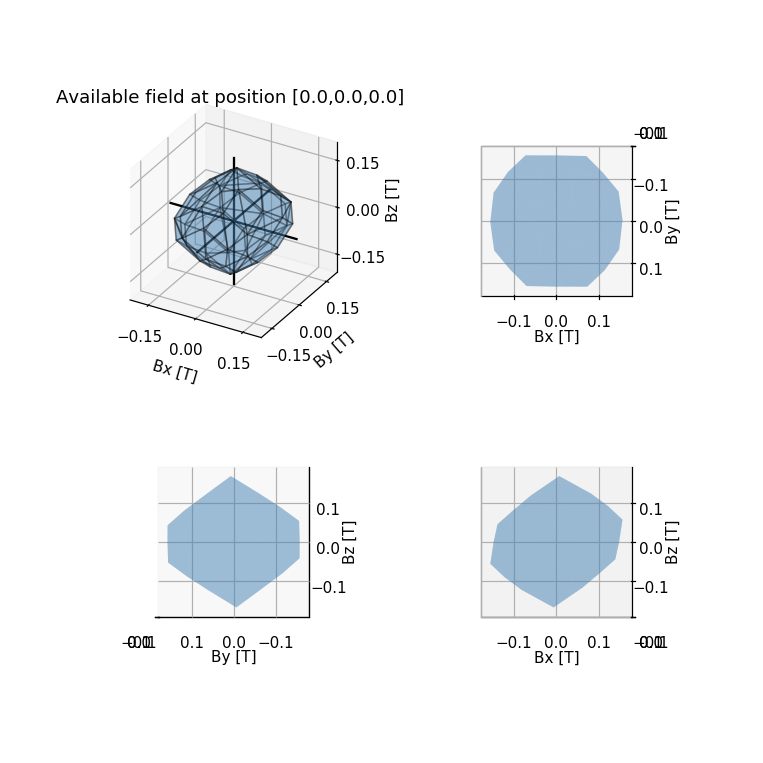

In [5]:
lim = 0.2
Imin = -20
Imax = 20

VecStart_x = [-lim,0.,0.]
VecStart_y = [0.,-lim,0.]
VecStart_z = [0.,0.,-lim]

VecEnd_x = [lim,0.,0.]
VecEnd_y = [0.,lim,0.]
VecEnd_z  =[0.,0.,lim]

position = np.array([0.0,0.0,0.0])
J = model_cmag.getFieldActuationMatrix(position)


fig = plt.figure(figsize=(7, 7))

#3d views
ax = fig.add_subplot(221,projection='3d', proj_type = 'ortho')
plotHull(ax,ComputeZonotopeVertices(position,Imin,Imax,J),'steelblue',0.3,inter=0.1,edge_color='black')
ax.plot([-lim,lim], [0.,0.], [0.,0.],color='black')
ax.plot([0.,0.],[-lim,lim],  [0.,0.],color='black')
ax.plot([0.,0.],[0.,0.],[-lim,lim],color='black')
ax.set_xlabel('Bx [T]')
ax.set_ylabel('By [T]')
ax.set_zlabel('Bz [T]')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))
ax.set_title('Available field at position [0.0,0.0,0.0]')

#Projections
ax = fig.add_subplot(222,projection='3d', proj_type = 'ortho',azim=-90,elev=-90)
plotHull(ax,ComputeZonotopeVertices(position,Imin,Imax,J),'steelblue',0.3,inter=0.1,set_edges=False)
ax.set_xlabel('Bx [T]')
ax.set_ylabel('By [T]')

ax = fig.add_subplot(223,projection='3d', proj_type = 'ortho',azim=180,elev=0)
plotHull(ax,ComputeZonotopeVertices(position,Imin,Imax,J),'steelblue',0.3,inter=0.1,set_edges=False)

ax.set_ylabel('By [T]')
ax.set_zlabel('Bz [T]')

ax = fig.add_subplot(224,projection='3d', proj_type = 'ortho',azim=-90,elev=0)
plotHull(ax,ComputeZonotopeVertices(position,Imin,Imax,J),'steelblue',0.3,inter=0.1,set_edges=False)
ax.set_xlabel('Bx [T]')
ax.set_zlabel('Bz [T]')


plt.show()

### Estimation at other positions

<IPython.core.display.Javascript object>


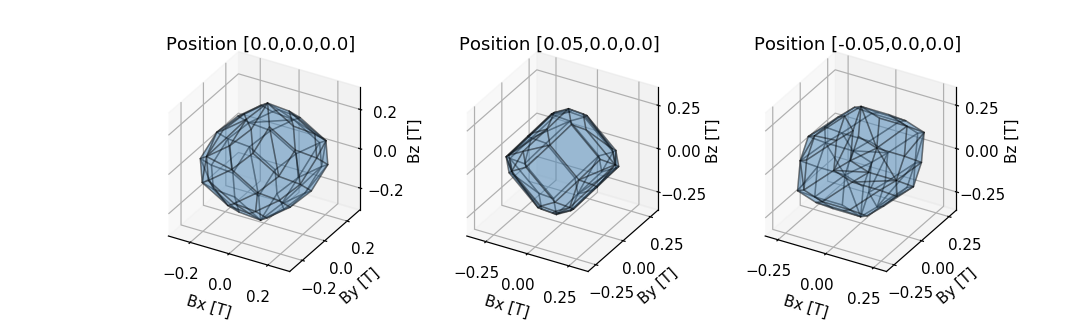

In [6]:
fig = plt.figure(figsize=(10, 3))

lim = 0.3

position = np.array([0.0,0.0,0.])
J = model_cmag.getFieldActuationMatrix(position)


ax = fig.add_subplot(131,projection='3d', proj_type = 'ortho')
plotHull(ax,ComputeZonotopeVertices(position,-35,35,J),'steelblue',0.3,inter=0.1,edge_color='black')
ax.set_xlabel('Bx [T]')
ax.set_ylabel('By [T]')
ax.set_zlabel('Bz [T]')
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
ax.set_title('Position [0.0,0.0,0.0]')


ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


position = np.array([0.05,0.,0.])
J = model_cmag.getFieldActuationMatrix(position)


ax = fig.add_subplot(132,projection='3d', proj_type = 'ortho')
plotHull(ax,ComputeZonotopeVertices(position,-35,35,J),'steelblue',0.3,inter=0.1,edge_color='black')
ax.set_xlabel('Bx [T]')
ax.set_ylabel('By [T]')
ax.set_zlabel('Bz [T]')
ax.set_title('Position [0.05,0.0,0.0]')


ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))


position = np.array([-0.05,0.,0.])
J = model_cmag.getFieldActuationMatrix(position)


ax = fig.add_subplot(133,projection='3d', proj_type = 'ortho')
plotHull(ax,ComputeZonotopeVertices(position,-35,35,J),'steelblue',0.3,inter=0.1,edge_color='black')
ax.set_xlabel('Bx [T]')
ax.set_ylabel('By [T]')
ax.set_zlabel('Bz [T]')
ax.set_title('Position [-0.05,0.0,0.0]')

ax.xaxis.set_major_locator(plt.MaxNLocator(3))
ax.yaxis.set_major_locator(plt.MaxNLocator(3))
ax.zaxis.set_major_locator(plt.MaxNLocator(3))

plt.show()